this notebook will be used to show the performance of the first attempt at learning reward.

first load the trained reward network anbd setup methods.

In [1]:
from baselines.common.vec_env import VecFrameStack
from LearningModel.AgentClasses import *
from baselines.common.cmd_util import make_vec_env
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from os import listdir
from os.path import isfile, join
import re

/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/patrick/PycharmP

In [2]:


#setup the env
model_path = "/home/patrick/models/Ant-v2-groundTruth-test"
env_id = 'Ant-v2'
env_type = 'mujoco'

env = make_vec_env(env_id, env_type, 1, 0,
                   wrapper_kwargs={
                       'clip_rewards': False,
                       'episode_life': False,
                   })
#env = VecFrameStack(env, 4)

#load the reward network
trainedNetwork = RewardNetwork("", env_type, env=env)

trainedNetwork.load_state_dict(torch.load("/home/patrick/models/ant-reward/fullTest.params"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = PPO2Agent(env, env_type, True)
trainedNetwork.to(device)

#run the agent in the env once and save the ground truth reward and observations
def GetDemoFromAgent(agent, network, env):
    trueReward = 0
    learnedReward = 0

    currentReward = 0
    currentObservation = env.reset()
    timeSteps = 0
    done = False

    #run the demo
    while True:
        trueReward += currentReward
        shapedObservation = torch.from_numpy(currentObservation).float().to(device)
        reward, abs_reward = network.predict_reward(shapedObservation)
        learnedReward += reward.tolist()

        action = agent.act(currentObservation,  currentReward, done)
        currentObservation, currentReward, done, info = env.step(action)
        shapedObservations = currentObservation
        timeSteps += 1

        if done:
            trueReward += currentReward
            reward, abs_reward = network.predict_reward(shapedObservation)
            learnedReward += reward.tolist()
            break
    print("{}, {}".format(trueReward, learnedReward))
    return trueReward, learnedReward

#a method to find all the models in a given dir that are just numbers
def Find_all_Models(model_dir):

    checkpoints = []
    filesandDirs = listdir(model_dir)
    allFiles = []
    for i in filesandDirs:
        if isfile(join(model_dir, i)):
            allFiles.append(i)

    for file in allFiles:
        if re.match('^[0-9]+$',file.title()):
            checkpoints.append(file.title())

    return checkpoints




Logging to /tmp/openai-2020-03-09-15-51-48-783903





Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use keras.layers.flatten instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


now load all models and run each to get demos to run the network on

In [8]:
trueRewards = []
learnedRewards = []

models = Find_all_Models(model_path)

for i in range(10):
    for model in models:
        agent.load(model_path + "/" + model)
        trueReward, learnedReward = GetDemoFromAgent(agent, trainedNetwork, env)
        tf.keras.backend.clear_session()
        trueRewards.append(trueReward[0])
        learnedRewards.append(learnedReward)
    
maxTrue = max(trueRewards)
maxLearned = max(learnedRewards)
normalisedRewards = learnedRewards / (maxLearned / maxTrue)


[-37.177223], 0.09193673409026815
[-2.695225], 0.9312322735786438
[-45.744946], -1.2477319142781198
[9.661291], 2.3667951248935424
[-107.98946], -1.2347099558683112
[-1.9903389], 0.8139713772106916
[-11.289309], 1.3808132882404607
[-35.00648], -1.4388778595020995
[-13.026652], 0.9482955248095095
[-8.968106], 0.46188279520720243
[-13.556521], -0.6314450160134584
[2.5456696], 1.946814930299297
[-20.515436], -0.7256053841847461
[-15.209562], 1.2499986989423633
[1.6736319], 5.432436224855337
[-30.566269], 0.014351825346238911
[-26.774202], 0.08844907389720902
[0.05108106], -0.4969696756452322
[-36.346798], 3.422877131313726
[-3.3297336], -0.3771380567923188
[9.55817], 3.0750947837905187
[-18.464914], 0.7989850983722135
[9.375874], 1.3324388086330146
[11.092585], 2.720387797919102
[-21.671303], -0.7329654692002805
[-37.64821], -1.8305717393523082
[-25.361168], 0.5907425624109237
[-2.273684], -0.31431216606870294
[-21.53998], -1.855750363174593
[-20.65229], 4.81528304470703
[-33.377914], 0.7

In [22]:

minLearned = min(learnedRewards)
normalisedRewards = [x-minLearned for x in learnedRewards]
copyLearned = []
copyTrue = []
for i in range(len(normalisedRewards)):
    if normalisedRewards[i] > 500000 or trueRewards[i] < -100:
        pass
    else:
        copyLearned.append(normalisedRewards[i])
        copyTrue.append(trueRewards[i])

minLearned = min(copyLearned)
copyLearned = [x-minLearned for x in copyLearned]

minTrue = min(copyTrue)
copyTrue = [x-minTrue for x in copyTrue] 
maxTrue = max(copyTrue)

maxLearned = max(copyLearned)
copyLearned = (copyLearned) / (maxLearned / maxTrue)

99.69340515136719,8.532609223471809


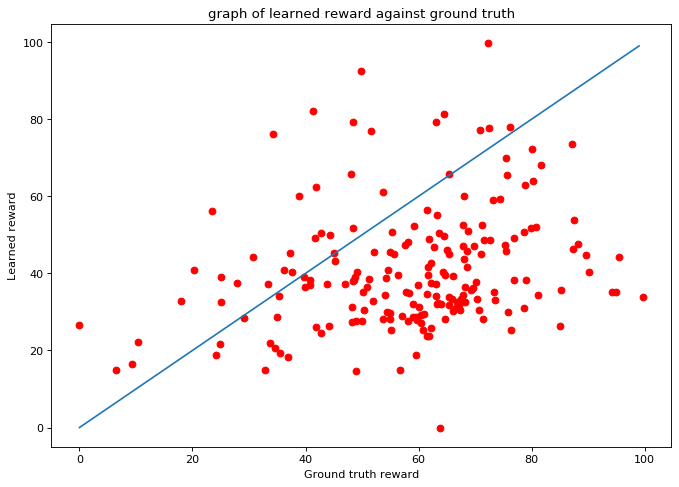

In [24]:
from matplotlib.pyplot import figure

print("{},{}".format(maxTrue, maxLearned))

figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(np.array(copyTrue), np.array(copyLearned), c='r')
plt.plot(np.arange(100), np.arange(100))
plt.ylabel("Learned reward")
plt.xlabel("Ground truth reward")
plt.title("graph of learned reward against ground truth")
plt.show()

In [11]:
minReward = [min(trueRewards)]
maxReward = [max(trueRewards)]
average = [sum(trueRewards) / len(trueRewards)]

from LearningModel.getAverageReward import *
agent.load("~/models/ant-reward-rl/ant_2M_ppo2")
meanR, minR,maxR, std = getAvgReward(agent, env, 20)

minReward.append(minR)
maxReward.append(maxR)
average.append(meanR)


mins: [-693.5162, -32.72865295410156], maxs: [29.147459, 38.64115905761719], means: [-29.079174617379905, -7.295126524567604]


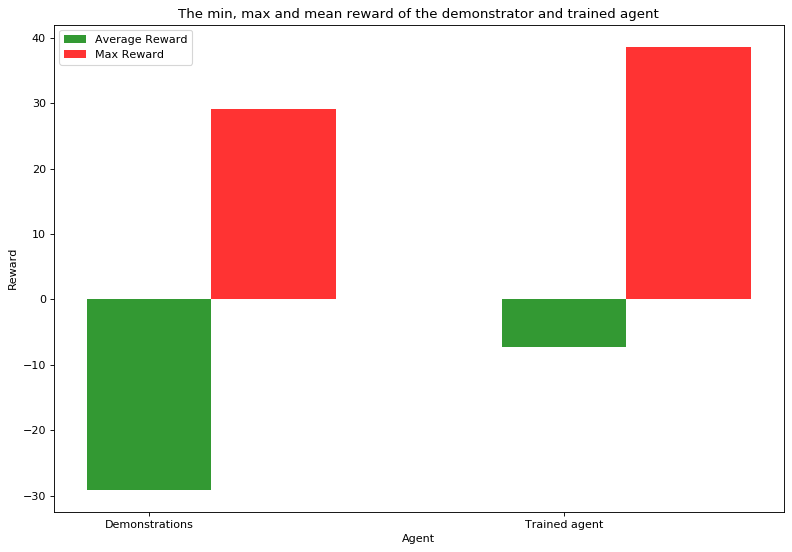

In [25]:
minReward[0] = min(trueRewards)
maxReward[0] = max(trueRewards)
average[0] = sum(trueRewards) /len(trueRewards)
print("mins: {}, maxs: {}, means: {}".format(minReward, maxReward, average))
# create plot
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
#fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.3
opacity = 0.8

'''
rects1 = plt.bar(index, minReward, bar_width,
alpha=opacity,
color='b',
label='Minimum Reward')
'''

rects2 = plt.bar(index + bar_width, average, bar_width,
alpha=opacity,
color='g',
label='Average Reward')

rects3 = plt.bar(index + bar_width +bar_width, maxReward, bar_width,
alpha=opacity,
color='r',
label='Max Reward')

plt.xlabel('Agent')
plt.ylabel('Reward')
plt.title('The min, max and mean reward of the demonstrator and trained agent')
plt.xticks(index + bar_width, ('Demonstrations', 'Trained agent'))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from baselines.common import plot_util as pu
results = pu.load_results('~/logs/Agent/mspacman')
pu.plot_results(results, average_group=True, split_fn=lambda _: '', figsize=(10, 7))